In [3]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras
from utils import utils 
from importlib import reload 
print(tf.__version__)

2.3.0


In [4]:
N = 100 # time disrectization    
m = 1 # dimension of price
S0 = 1 # initial value of the asset
T = 1 # maturity
strike = 1.0
option_type = 'eurodigitalcall'
if option_type == 'eurocall':
    payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # European call option payoff
if option_type == 'eurodigitalcall':
    payoff_function = lambda x : (x-strike) > 0 # European digital call option payoff

In [5]:
# GBM
sigma=0.2 # volatility in Black Scholes  
Ktrain = 10**5

In [7]:
alpha = 0.005
beta = 10
def build_dynamic(m, N, control_path, trans_cost):    
    l_hidden = 2 # number of hidden layers in strategy
    width = m + 15  # nodes in the first but last layers
    Networks = utils.build_network(m, width , l_hidden+1, N)
    Network0 = keras.layers.Dense(m, use_bias=False)

    price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
    payoff = keras.Input(shape=(1))
    benchmark_hedge = keras.Input(shape=(N+1,m))   # V_{t}; t=0,..,N+1; (batch, N+1, m)
    
    if control_path:
        inputs = [price, payoff, benchmark_hedge]
    else:
        inputs = [price, payoff]
        
    price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
    premium = Network0(tf.ones_like(price[:,0,:])) # premium; (batch, m)
    
    HEDGE = [None]*(N+1)
    HEDGE[0] = tf.zeros_like(price[:,0,:]) + premium
    
    STRATEGY = [None]*N
    for j in range(N):
        
        log_price = tf.math.log(price[:,j,:1])
        history = tf.reduce_min(price[:,:j+1,1:], axis = 1)
        I = tf.concat([log_price, history], axis = -1)
        STRATEGY[j] = Networks[j](I)  
        cost = 0
        if trans_cost: 
            if j > 0:
                cost = alpha*((STRATEGY[j]- STRATEGY[j-1])*price[:,j,:])**2
        HEDGE[j+1] = HEDGE[j] + STRATEGY[j] * price_difference[:,j,:] - cost # dX_{t} = H_{t}dS_{t}; (batch, m)
    payoff_hedge = tf.math.reduce_sum(HEDGE[-1],axis = -1, keepdims = True) # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)
    outputs = tf.concat([h[:,None,:] for h in HEDGE], axis = 1)
    model_hedge = keras.Model(inputs = inputs, outputs= outputs)
    
    mse = tf.keras.losses.MeanSquaredError()
    model_hedge.add_loss(mse(payoff_hedge, payoff)) 
    if control_path:
        for j in range(N):
            model_hedge.add_loss(beta * mse(HEDGE[j], benchmark_hedge[:,j]))
                
    return model_hedge, Networks, Network0


In [8]:
class Model_hedge:
    def __init__(self, m, N, control_path, trans_cost):
        self.m = m
        self.N = N
        self.control_path = control_path
        self.trans_cost = trans_cost
        self.model, self.Networks, self.Network0 = build_dynamic(m, N, control_path, trans_cost)   
    def prepare_data(self, time_grid, price_path, option_path, payoff, delta_path, option_type):
        self.delta_path = delta_path
        self.option_type = option_type
        self.time_grid = time_grid
        self.option_path = option_path
        self.price_path = price_path
        self.payoff = payoff
        Ktrain = price_path.shape[0]
        split = int(Ktrain/2)
        self.split = split
        if not self.control_path:
            option_path = price_path
            self.xtrain = [price_path[:split],payoff[:split]]  
            self.ytrain = payoff[:split]*0
            self.xtest = [price_path[split:],payoff[split:]] 
            self.ytest = payoff[split:]*0
        else:
            self.xtrain = [price_path[:split],payoff[:split],option_path[:split]]  
            self.ytrain = payoff[:split]*0
            self.xtest = [price_path[split:],payoff[split:],option_path[split:]] 
            self.ytest = payoff[split:]*0 
    def train(self, epochs, verbose):
        def zeroloss(y_true, y_predict):
            return tf.reduce_sum(y_true*0)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
        self.model.compile(optimizer = optimizer, loss=zeroloss) 
        self.model.fit(x=self.xtrain,y=self.ytrain, epochs=epochs,verbose=verbose,batch_size=1000) # train the model 
    def predict(self):
        self.hedge_output_train = self.model.predict(self.xtrain) 
        self.hedge_output_test = self.model.predict(self.xtest) 
        return self.hedge_output_train, self.hedge_output_test
    def plot(self,price_path, payoff, delta_output):
        self.delta_output = delta_output
        split = self.split
        f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
        p[0].scatter(price_path[split:,-1,0], self.hedge_output_test[:,-1,0], s = 1, alpha = 0.5, label = 'deep hedge test ')   # deep replicate payoff 
        p[1].scatter(price_path[:split,-1,0], self.hedge_output_train[:,-1,0], s = 1, alpha = 0.5, label = 'deep hedge train')   # deep replicate payoff 
        p[2].scatter(price_path[:,-1,0], delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
        for i in range(3):
            p[i].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
            p[i].legend()
            p[i].grid()
        plt.show()
        print(f"deep premium: {self.Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{5}}")         # premium of deep hedge (truncted printing)
        helper,_ = utils.BlackScholes(T, S0, strike, sigma, self.option_type)
        print(f"real premium: {helper:{1}.{5}}")           # real premium
        

time_grid_type:  equi-exp
control_path:  False
trans_cost:  False
Epoch 1/20
50/50 [==============================] - 1s 13ms/step - loss: 0.1778
Epoch 2/20
50/50 [==============================] - 1s 14ms/step - loss: 0.0230
Epoch 3/20
50/50 [==============================] - 1s 13ms/step - loss: 0.0143
Epoch 4/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0129
Epoch 5/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0120
Epoch 6/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0115
Epoch 7/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0112
Epoch 8/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0110
Epoch 9/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0108
Epoch 10/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0108
Epoch 11/20
50/50 [==============================] - 1s 12ms/step - loss: 0.0106
Epoch 12/20
50/50 [==============================] -

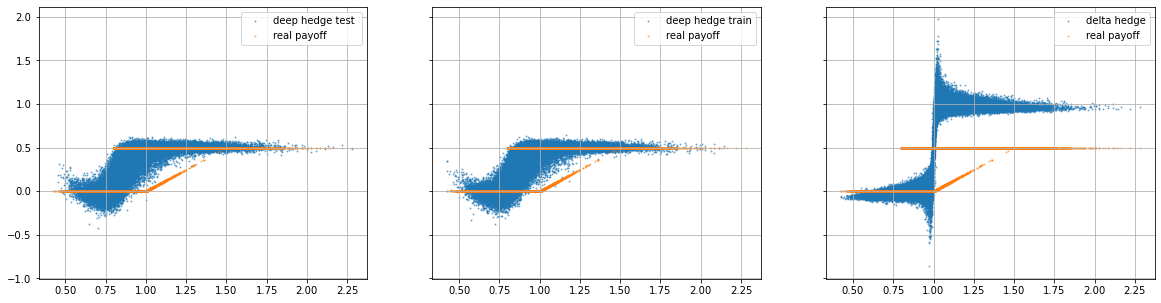

deep premium: 0.36563
real premium: 0.46017


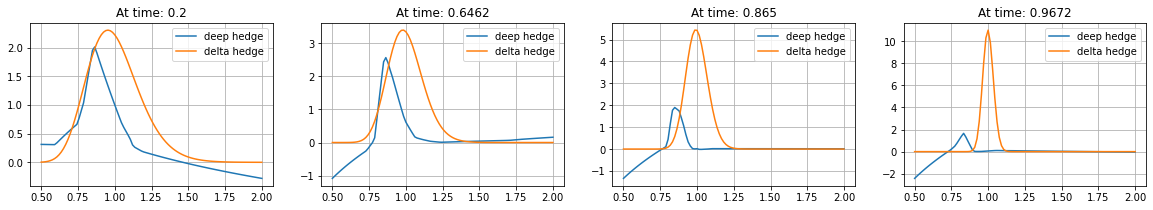

In [9]:
MODEL = []
barrier = 0.8
rebate = 0.5
payoff_function = lambda x, y : 0.5*(np.abs(x-strike)+x-strike)*(y<=barrier) + rebate*(y>barrier)
time_grid_type = 'equi-exp'
price_path, time_grid = utils.simulate_GBM(m,Ktrain,N,T,0,sigma,S0,time_grid_type)
price_path_min = np.min(price_path,axis = 1)
payoff = payoff_function(price_path[:,-1,:],price_path_min) 
delta_output, delta_path, option_path = utils.delta_hedge(price_path,payoff,T,strike,sigma,option_type,time_grid)
control_path = False
trans_cost = False
print('time_grid_type: ',time_grid_type)
print('control_path: ', control_path)
print('trans_cost: ', trans_cost)

model_hedge = Model_hedge(m, N, control_path, trans_cost)
model_hedge.prepare_data(time_grid, price_path, option_path, payoff, delta_path, option_type)
model_hedge.train(epochs = 20,verbose = True)
model_hedge.predict()
model_hedge.plot(price_path, payoff, delta_output)
MODEL.append(model_hedge)
